# Inference demo for VideoRefer (combined with SAM2)

## Setup

In [1]:
import math
import os
import argparse
import json
import warnings
from tqdm import tqdm
import transformers
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence, List
import torch
import sys
sys.path.append('../../')
from videorefer import model_init, mm_infer
from pycocotools import mask as maskUtils
import numpy as np
from videorefer.mm_utils import process_video
from functools import partial
from matplotlib import pyplot as plt
from PIL import Image
from videorefer.utils import disable_torch_init        
from decord import VideoReader, cpu

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

    
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

using device: cuda


## load model

In [2]:
disable_torch_init()

# fill in the model path here
model_path = 'DAMO-NLP-SG/VideoRefer-7b'
model, processor, tokenizer = model_init(model_path)

for m in model.modules():
    m.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## load video and visualize frame

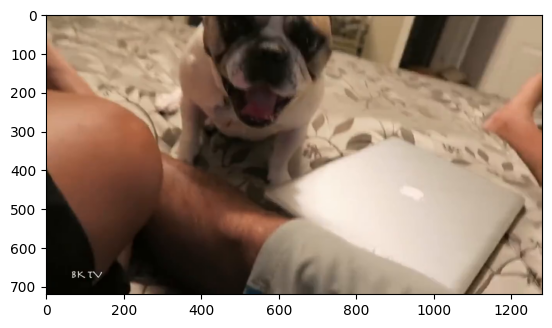

In [3]:
video_path = 'assets/dog.mp4'
# default to 0
frame_idx = 0

vreader = VideoReader(video_path, ctx=cpu(0), num_threads=1)
num_frames_of_video = len(vreader)
try:
    frame_data = vreader.get_batch([frame_idx]).asnumpy()[0]
except:
    frame_data = vreader.get_batch([frame_idx]).numpy()[0]
plt.imshow(frame_data)

## Single-frame mode

#### 1.Selecting Objects with SAM2

In [4]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
predictor.set_image(frame_data)

input_box = np.array([300, 0, 800, 430])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

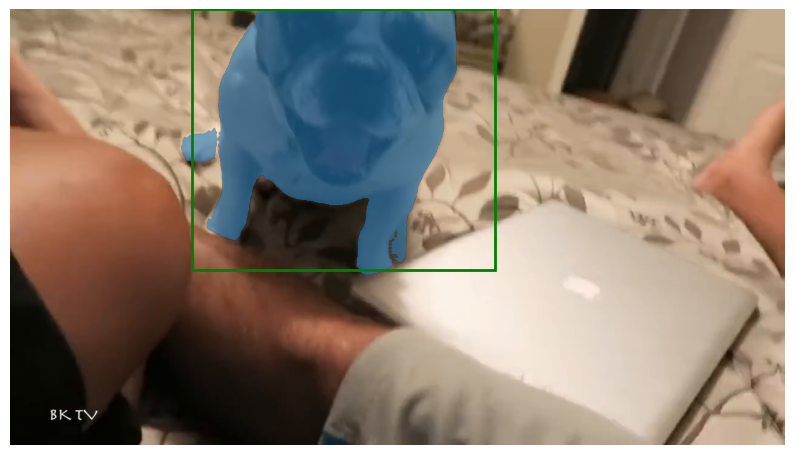

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(frame_data)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

#### 2. Inference with VideoRefer

In [7]:
question = 'Describe the [<region>] in detail in the video.'

video_tensor, frame_tensor, height, width = process_video(video_path, processor=processor, aspect_ratio='square', frame_idx=[frame_idx])

masks_ = np.array(masks)
masks_tensor = torch.Tensor(masks_)
masks_tensor = masks_tensor.unsqueeze(0)

frame_nums = [1]
ann_indices = [[[0]]]

output = mm_infer(
        video_tensor,
        question,
        model=model,
        tokenizer=tokenizer,
        masks=masks_tensor.cuda(),
        frame=frame_tensor,
        ann_indices=ann_indices,
        frame_nums=frame_nums,
    )
print(output)

  warnings.warn(

  warnings.warn(

  warnings.warn(



The French Bulldog in the video is small and has a white coat with brown patches. It is sitting on a bed next to a person who is using a laptop. The dog appears to be calm and is looking around, occasionally moving its head.


## Multi-frame mode

#### Step 1. Use SAM2 to segment&track one object

In [8]:
from sam2.build_sam import build_sam2_video_predictor
sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
inference_state = predictor.init_state(video_path=video_path)
predictor.reset_state(inference_state)


Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(



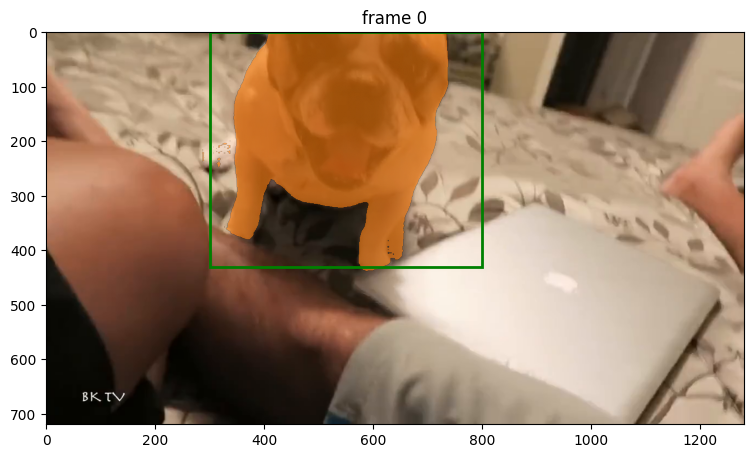

In [9]:

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([300, 0, 800, 430], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame_data)
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step3: Propagate the prompts to get the masklet across the video

propagate in video:  11%|█▏        | 17/150 [00:02<00:23,  5.60it/s]

propagate in video: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s]


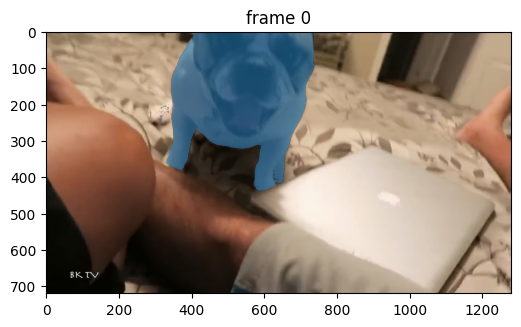

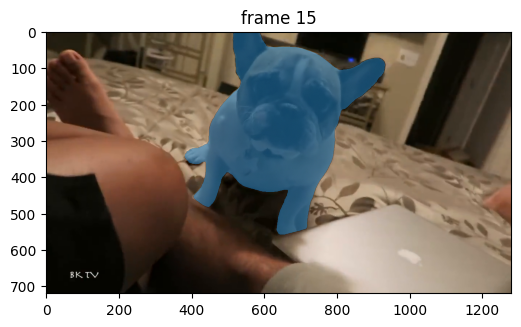

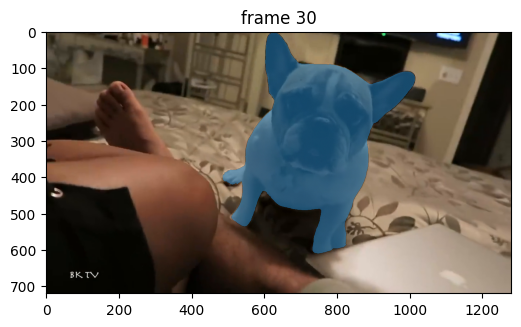

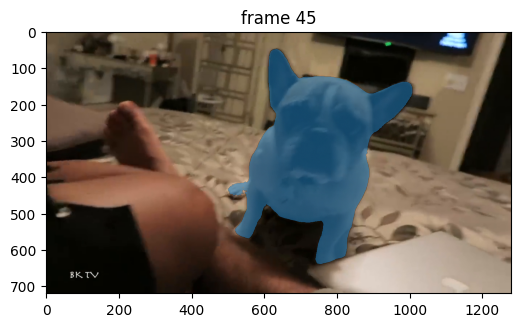

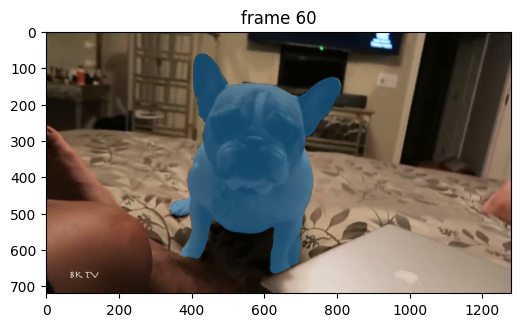

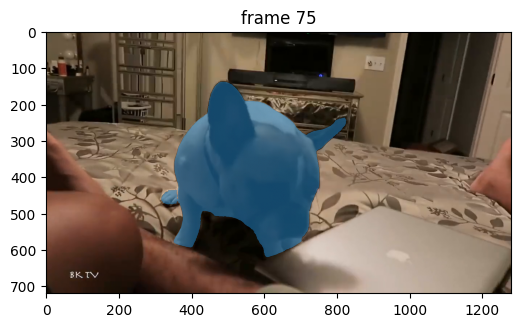

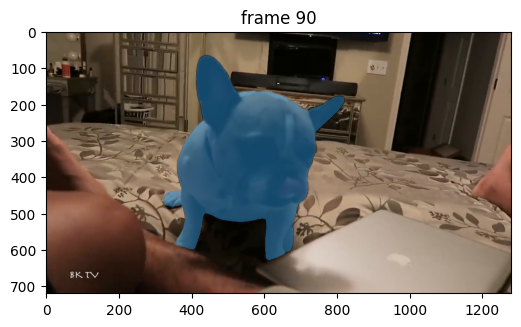

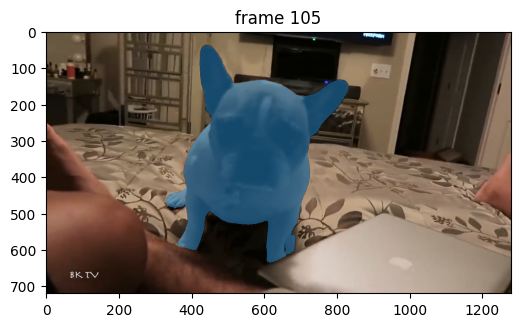

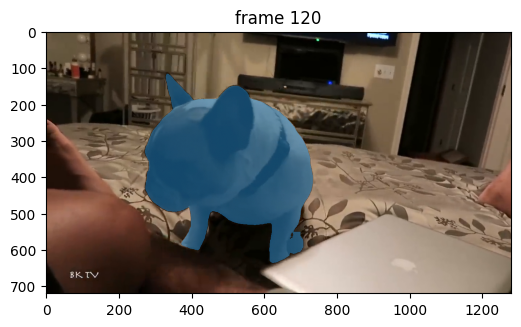

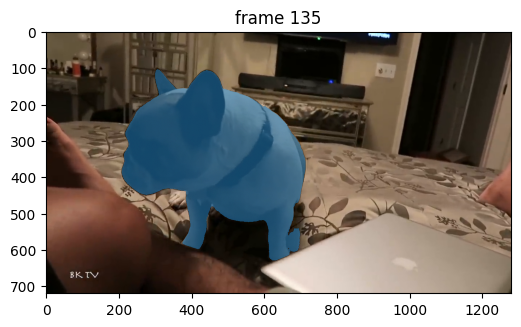

In [10]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = (out_mask_logits[0] > 0.0).cpu().numpy()
        

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, num_frames_of_video, vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    try:
        frame_ = vreader.get_batch([out_frame_idx]).asnumpy()[0]
    except:
        frame_ = vreader.get_batch([out_frame_idx]).numpy()[0]
    plt.imshow(frame_)
    show_mask(video_segments[out_frame_idx], plt.gca(), obj_id=0)

In [11]:
def uniform_sample(ids, sample_size):
    length = len(ids)
    if sample_size > length:
        raise ValueError("Sample size cannot be greater than the number of IDs.")
    
    step = length / sample_size
    sampled_ids = [ids[int(i * step)] for i in range(sample_size)]
    return sampled_ids

#### Step 4: Inference with VideoRefer (multi-frame mode)

In [12]:
question = 'Describe the [<region>] in detail in the video.'

sampled_frame_nums = 32
sampled_ids = uniform_sample(list(video_segments.keys()), sampled_frame_nums)

video_tensor, frame_tensor, height, width = process_video(video_path, processor=processor, aspect_ratio='square', frame_idx=sampled_ids)

mask_list = []
for sampled_id in sampled_ids:
    mask_list.append(video_segments[sampled_id][0])
    
masks = np.array(mask_list)
masks_tensor = torch.Tensor(masks)
masks_tensor = masks_tensor.unsqueeze(0)

frame_nums = [len(sampled_ids)]
ann_indices = [[[i for i in range(frame_nums[0])]]]

output = mm_infer(
        video_tensor,
        question,
        model=model,
        tokenizer=tokenizer,
        masks=masks_tensor.cuda(),
        frame=frame_tensor,
        ann_indices=ann_indices,
        frame_nums=frame_nums,
    )
print(output)

The French Bulldog in the video is small and has a white coat with brown patches. It is sitting on a bed next to a person who is using a laptop. The dog appears to be calm and is looking around, occasionally moving its head.
